
## Print figures of Himawari SST data in regions (distributed)


In [1]:
import os, sys, shutil
from glob import glob
#
%matplotlib inline
#matplotlib.use('agg')
import matplotlib.pyplot as plt
import xarray as xr
from dask import compute, delayed
from dask.distributed import Client
# 
from datetime import datetime
import pandas as pd
#
from utils import *

/home1/datahome/aponte/distributed/distributed/utils.py:128: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  % (host, default, e), RuntimeWarning)
/home1/datahome/aponte/.miniconda3/envs/pangeon/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


satpy not available


In [2]:
### get dask handles and check dask server status
client = Client(scheduler_file=os.path.expanduser('/home1/datawork/aponte/dask/scheduler.json'))
#client = Client(scheduler_file=os.path.expanduser('/home1/scratch/aponte/dask/scheduler.json'), )
#client = Client(scheduler_file=os.path.expanduser('/home1/scratch/aponte/dask/scheduler.json'), timeout='20s')
#client.restart()
# upload utils.py to workers
#client.upload_file('/home1/datahome/aponte/iwave_sst/hw/utils.py')
#client.upload_file('utils.py')

In [3]:
client

Client Scheduler: tcp://10.148.1.32:8786 Dashboard: http://10.148.1.32:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [21]:
client.restart()

Client Scheduler: tcp://10.148.1.13:8786 Dashboard: http://10.148.1.13:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [6]:
client.upload_file('/home1/datahome/aponte/iwave_sst/hw/utils.py')
#client.upload_file('utils.py')

In [7]:
client

Client Scheduler: tcp://10.148.1.19:8786 Dashboard: http://10.148.1.19:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [6]:
#client.upload_file('/home1/datahome/aponte/iwave_sst/hw/utils.py')

In [12]:
# data path
region = 'NWA'; vmin = 20.; vmax = 35.
region = 'NWAM'; vmin = 26.; vmax = 32.
region = 'WA'; t1, t2, suff, vmin, vmax, slat, slon = datetime(2016,9,3), datetime(2016,9,16), '_t1z', 23., 30., slice(-12,-24), slice(108,126)

#
dpath = '/home/datawork-lops-osi/data/hw/sst/'+region+'/';
#figdir = '/home1/datawork/aponte/hw/figs/'

filenames = sorted(glob(dpath+region+'_*.nc'))
print('Number of files available: %d' %len(filenames))
Nfiles = len(filenames)
# tmp, subset number of files (skip last file that may be incomplete)
#filenames = filenames[:-1]

# consider a time subset
times = [datetime.strptime(f,dpath+region+'_%Y%m%d%H%M.nc') for f in filenames]
if 't1' in locals() and 't2' in locals():
    filenames  = [f for f,t in zip(filenames,times) if (t>t1) and (t<t2)]
print('Number of files processed: %d' %len(filenames))

Number of files available: 42690
Number of files processed: 1842


In [13]:
# open files
%time ds = xr.open_mfdataset(filenames, concat_dim='time', compat='equals')

# spatial zoom
if 'slat' in locals():
    ds = ds.sel(lat=slat)

# sst in degC
ds['sea_surface_temperature'] += -273.15
ds['sea_surface_temperature'] = ds['sea_surface_temperature'].where(ds['sea_surface_temperature']>0)

print('SST dataset size: %.1f GB' %(ds['sea_surface_temperature'].nbytes/1e9))

CPU times: user 31.4 s, sys: 2.05 s, total: 33.5 s
Wall time: 1min 11s
SST dataset size: 4.4 GB


In [7]:
ds

<xarray.Dataset>
Dimensions:                  (lat: 601, lon: 1001, time: 1842)
Coordinates:
  * lat                      (lat) float32 -12.0 -12.019997 -12.040001 ...
  * lon                      (lon) float32 105.0 105.02 105.04 105.06 105.08 ...
  * time                     (time) datetime64[ns] 2016-09-03T00:10:17 ...
Data variables:
    sea_surface_temperature  (time, lat, lon) float32 dask.array<shape=(1842, 601, 1001), chunksize=(1, 601, 1001)>
    wind_speed               (time, lat, lon) float32 dask.array<shape=(1842, 601, 1001), chunksize=(1, 601, 1001)>
    solar_zenith_angle       (time, lat, lon) float32 dask.array<shape=(1842, 601, 1001), chunksize=(1, 601, 1001)>
Attributes:
    Conventions:                CF-1.4,Unidata Observation Dataset v1.0
    title:                      Sea Surface Temperature from AHI onboard Hima...
    summary:                    TBD
    references:                 TBD
    institution:                Japan Aerospace Exploration Agency(JAXA)
  

---

# mean quantities

KeyboardInterrupt: 

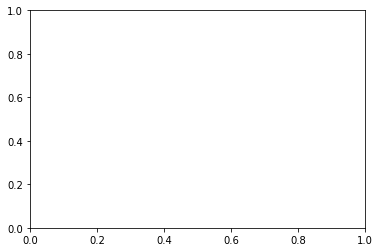

In [14]:
Tmean_xt = ds['sea_surface_temperature'].mean(['lon','time']).persist()
Tmean_xt.plot()

In [ ]:
Tmean_xy = ds['sea_surface_temperature'].mean(dim=['lon','lat'])
Tmean_xy.plot()
plt.grid()

In [ ]:
Tmean_t = ds['sea_surface_temperature'].mean('time').persist()

In [ ]:
plot_sst(Tmean_t, title='Temporal average', vmin=22., vmax=28., figsize=(15,10))

---

# diurnal cycle

In [ ]:
Tdcycle = (ds['sea_surface_temperature'].mean('lon') - Tmean_xt).groupby('time.hour').mean('time')
Tdcycle = Tdcycle.persist()

In [ ]:
Tdcycle

In [ ]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
Tdcycle.T.plot(ax=ax)

In [ ]:
Tdcycle.mean('lat').plot()
plt.grid()

---

# zonally averaged temperature

In [ ]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
(ds['sea_surface_temperature'].mean('lon') - Tmean_xt).T.plot(ax=ax, vmin=-1., vmax=1.)
plt.grid()

In [ ]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
#ds['wind_speed'].mean('lon').T.plot(ax=ax, vmin=-1., vmax=1.)
ds['wind_speed'].mean('lon').T.plot(ax=ax)

---

# At single longitudes

In [ ]:
T = ds['sea_surface_temperature'].sel(lon=116.,method='nearest')
T = T.sel(lat=slice(-15.,-21.5))
#T = T.sel(time=slice('2016-09-04','2016-09-15'))
T += -T.mean('time')

In [ ]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
T.T.plot(ax=ax, vmin=-1., vmax=1.)
ax.grid()

In [ ]:
T = ds['sea_surface_temperature'].sel(lon=120.,method='nearest')
T = T.sel(lat=slice(-12.,-20.))
#T = T.sel(time=slice('2016-09-04','2016-09-15'))
T += -T.mean('time')

In [ ]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
T.T.plot(ax=ax, vmin=-1., vmax=1.)
ax.grid()

In [ ]:
# clean up memory
del Tdcycle, Tmean_xt, Tmean_t

---

# make movie

In [14]:
#client.upload_file('/home1/datahome/aponte/iwave_sst/hw/utils.py')
client.upload_file('utils.py')

distributed.utils - ERROR - [Errno 2] No such file or directory: '/home1/scratch/aponte/dask/worker-eroo8d_7/utils.py'
Traceback (most recent call last):
  File "/home1/datahome/aponte/.miniconda3/envs/pangeod0160/lib/python3.6/site-packages/distributed/utils.py", line 238, in f
    result[0] = yield make_coro()
  File "/home1/datahome/aponte/.miniconda3/envs/pangeod0160/lib/python3.6/site-packages/tornado/gen.py", line 1099, in run
    value = future.result()
  File "/home1/datahome/aponte/.miniconda3/envs/pangeod0160/lib/python3.6/site-packages/tornado/gen.py", line 1107, in run
    yielded = self.gen.throw(*exc_info)
  File "/home1/datahome/aponte/.miniconda3/envs/pangeod0160/lib/python3.6/site-packages/distributed/client.py", line 2320, in _upload_file
    'data': to_serialize(data)})
  File "/home1/datahome/aponte/.miniconda3/envs/pangeod0160/lib/python3.6/site-packages/tornado/gen.py", line 1099, in run
    value = future.result()
  File "/home1/datahome/aponte/.miniconda3/envs/p

FileNotFoundError: [Errno 2] No such file or directory: '/home1/scratch/aponte/dask/worker-eroo8d_7/utils.py'

In [12]:

figdir = '/home1/datawork/aponte/hw/figs/'
shutil.rmtree(figdir); os.mkdir(figdir)

def process(lds, i, overwrite=True):
    sst = lds['sea_surface_temperature']
    #
    time = pd.to_datetime(str(sst['time'].values))
    figname = figdir+'hw_sst_'+region+'_'+time.strftime('%Y%m%d_%H%M')+suff+'.png'
    #
    if not os.path.isfile(figname) or overwrite:
        #
        title = time.strftime('%Y%m%d_%H%M')
        plot_sst(sst, colorbar=False, title=title, savefig=figname) #, vmin=vmin, vmax=vmax, 
        #         offline=True, coast_resolution='50m', figsize=(15,10))
        #
        m = float(sst.mean().values)
    else:
        m = -1.
    return m

I = range(len(ds['time']))
I = range(5)
#values = [delayed(process)(ds['sea_surface_temperature'].isel(time=i), i) for i in I]
values = [delayed(process)(ds.isel(time=i), i) for i in I]
#print(values[:5])


In [13]:
results = compute(*values, get=client.get)

distributed.utils - ERROR - No module named 'utils'
Traceback (most recent call last):
  File "/home1/datahome/aponte/.miniconda3/envs/pangeo/lib/python3.6/site-packages/distributed/utils.py", line 238, in f
    result[0] = yield make_coro()
  File "/home1/datahome/aponte/.miniconda3/envs/pangeo/lib/python3.6/site-packages/tornado/gen.py", line 1099, in run
    value = future.result()
  File "/home1/datahome/aponte/.miniconda3/envs/pangeo/lib/python3.6/site-packages/tornado/gen.py", line 1107, in run
    yielded = self.gen.throw(*exc_info)
  File "/home1/datahome/aponte/.miniconda3/envs/pangeo/lib/python3.6/site-packages/distributed/client.py", line 1378, in _gather
    traceback)
  File "/home1/datahome/aponte/.miniconda3/envs/pangeo/lib/python3.6/site-packages/six.py", line 692, in reraise
    raise value.with_traceback(tb)
  File "/home1/datahome/aponte/.miniconda3/envs/pangeo/lib/python3.6/site-packages/distributed/protocol/pickle.py", line 59, in loads
    return pickle.loads(x)
M

ModuleNotFoundError: No module named 'utils'

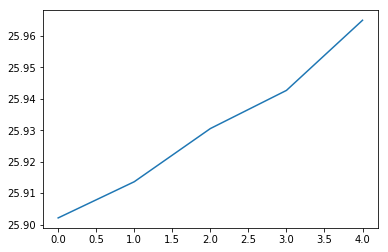

In [36]:
plt.plot(results)

In [26]:
# with delayed
def process(lds, i):
    sst = lds['sea_surface_temperature']
    #
    m = float(sst.mean().values)
    return m

I = range(len(ds['time']))
values = [delayed(process)(ds.isel(time=i), i) for i in I]
#print(values[:5])

In [27]:
results = compute(*values, get=client.get)

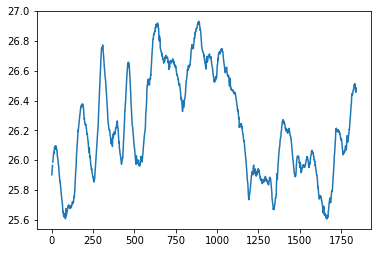

In [28]:
plt.plot(results)

In [24]:

# with apply_ufunc
def process(T, lon, lat, time):
    #
    #plot_sst(sst, colorbar=False, title=title, savefig=figname, 
    #         vmin=vmin, vmax=vmax, offline=True, coast_resolution='50m', figsize=(15,10))
    #
    plt.switch_backend('agg')
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.imshow(T.squeeze())
    #figname = figdir+'hw_sst_'+region+'_'+time.strftime('%Y%m%d_%H%M')+suff+'.png'    
    figname = figdir+'hw_sst_'+region+'_'+str(time)+'.png'    
    fig.savefig(figname, dpi=150)
    plt.close(fig)
    #
    m = np.nanmean(np.nanmean(T,axis=1),axis=1)
    return m
    
M = xr.apply_ufunc(process, ds['sea_surface_temperature'].isel(time=slice(0,10)), 
                   ds['lon'], ds['lat'], ds['time'].isel(time=slice(0,10)),
                   input_core_dims=[['lon','lat'],['lon'],['lat'],[]], 
                   dask='parallelized', output_dtypes=[float])

print(M)

1842

In [ ]:
M.compute()